### 0.1 Import Package

In [31]:
import os
import re
import sys
import copy
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import utils
from torchvision import datasets, models, transforms
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0")

PyTorch Version:  2.1.0+cu121
Torchvision Version:  0.16.0+cu121


### 0.2. Directory Setting

In [2]:
# from model.models import Conv4
from model.pretrained_models import get_pretrain_model
from dataset_dir.datasets import datasetload

In [22]:
MODEL_DIR = "./model/weight/"
LOG_DIR = "./results/log/"

**Specific model setting**: 특정한 모델을 확인하기 위해

In [12]:
RECURSIVE = False

conf = dict(
    epoch=100,
    lr=0.001,
    stepsize=50,
    gamma=0.1,
    model="alexnet",
    dataset="cifar10",
    pretrain=False,
    mode="cus",
    freeze="01011"
)
setting = "epoch"+str(conf['epoch'])+"_lr"+str(conf['lr'])

if conf["pretrain"] :
    name = "pretrain/"+str(conf['model'])+"/"+str(conf['dataset'])+"_"+setting
else :
    if str(conf["mode"]) == "cus":
        setting += "_freeze"+str(conf['freeze'])+"111"
        name = "custom/"+str(conf['model'])+"/"+str(conf['dataset'])+"_"+setting
    else :
        name = "optimal/"+str(conf['model'])+"/"+str(conf['dataset'])+"_"+setting
model_path = MODEL_DIR + name +".pt"
log_path = LOG_DIR +  name


print(model_path)
print(log_path)

./model/weight/custom/alexnet/cifar10_epoch100_lr0.001_freeze01011111.pt
./results/log/custom/alexnet/cifar10_epoch100_lr0.001_freeze01011111


**Entire model setting**: directory에 저장되어있는 전체 모델을 확인하기 위해

In [23]:
RECURSIVE = True
MODEL_DIR += "custom/alexnet/"
LOG_DIR += "custom/alexnet/"


weight_files = [os.path.join(MODEL_DIR, file) for file in os.listdir(MODEL_DIR) if os.path.isfile(os.path.join(MODEL_DIR, file))]
log_files = [os.path.join(LOG_DIR, file) for file in os.listdir(LOG_DIR)]

print(len(weight_files))
print(weight_files[0])
print(len(log_files))
print(log_files[0])

4
./model/weight/custom/alexnet/cifar100_epoch100_lr0.001_freeze01011111.pt
4
./results/log/custom/alexnet/cifar100_epoch100_lr0.001_freeze01011111


In [32]:
# for prototype
def name_parser(path):
    parts = path.split("/")
    mode = parts[3]
    model = parts[4]
    sub_parts = parts[5].split("_")
    dataset = sub_parts[0]
    freeze = sub_parts[3].split(".")[0]
    freeze = ''.join(re.findall(r'\d+', freeze))
    return mode, model, dataset, freeze

# EXAMPLE
mode, model, dataset, freeze = name_parser(weight_files[0])
print(mode, model, dataset, freeze)

custom alexnet cifar100 01011111


# 1. Architecture

In [33]:
trainloader, validloader, testloader, num_class = datasetload(conf['dataset'])
model = get_pretrain_model(conf['model'], num_class)
model_state = torch.load(model_path)
model.load_state_dict(model_state)

Files already downloaded and verified
Files already downloaded and verified


<All keys matched successfully>

### 1.1 Model Architecture

In [34]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [35]:
summary(model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

### 1.2 Dataset Distribution

In [36]:
print(num_class)
print(len(trainloader.dataset))
print(len(testloader.dataset))

10
40000
10000


torch.Size([3, 224, 224])
5


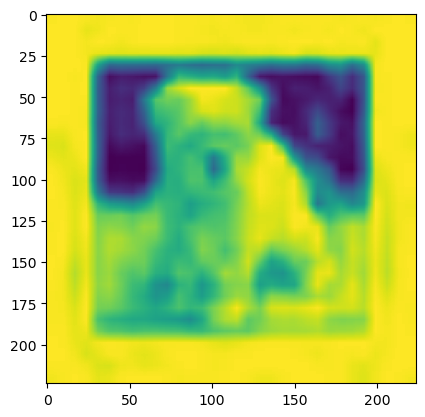

In [45]:
print(trainloader.dataset[0][0].shape)

plt.imshow(trainloader.dataset[2][0][0])
plt.show()

### Log Print

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Loss/train', 'Acc/train', 'Loss/val', 'Acc/val'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


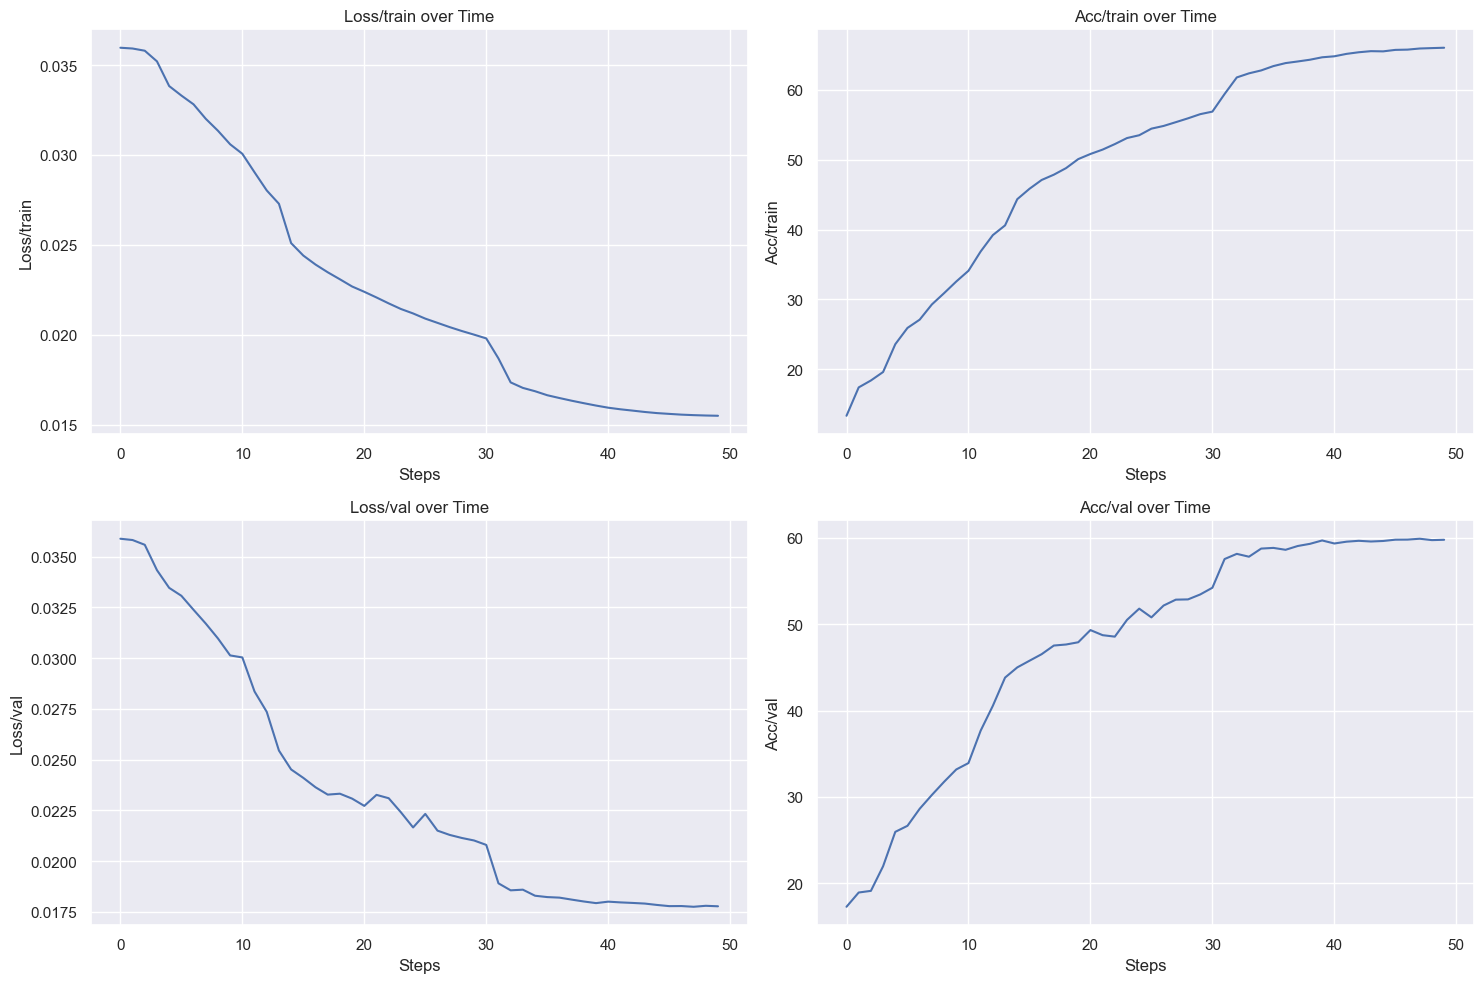

In [8]:
event_acc = EventAccumulator(log_path)
event_acc.Reload()

print(event_acc.Tags())

if 'scalars' in event_acc.Tags():
    scalar_tags = event_acc.Tags()['scalars']

    plt.figure(figsize=(15, 10))
    sns.set()

    for i, tag in enumerate(scalar_tags):
        values = event_acc.Scalars(tag)
        steps = [v.step for v in values]
        data = [v.value for v in values]
        
        df = pd.DataFrame({'Step': steps, tag: data})

        plt.subplot(2, 2, i + 1)
        sns.lineplot(x='Step', y=tag, data=df)
        plt.xlabel('Steps')
        plt.ylabel(tag)
        plt.title(f'{tag} over Time')

    plt.tight_layout()
    plt.show()

### Visualization
- `filters_visualize` : 모델을 이루는 각각의 convolution 필터의 가중치를 시각화 합니다. (constraint: 1st channel)
- `feature_map_visualize` : 특정 입력 이미지에 대해 모델의 각 레이어를 통과했을 때 feature_map을 시각화 합니다. (constraint: 1st feature map)
- `weight_distribution_visualize` : 모델을 이루는 각각의 레이어의 가중치 분포를 시각화 합니다. 

In [9]:
from visualize_tool import filters_visualize

In [10]:
layer_names = [name for name, _ in model.named_modules()]
print(layer_names)

['', 'conv1', 'conv2', 'conv3', 'conv4', 'maxpool1', 'maxpool2', 'fc']


torch.Size([16, 3, 3, 3])


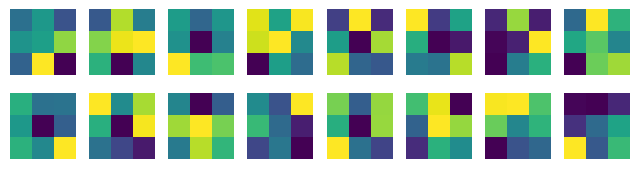

In [11]:
layer_name = "conv1"
filters_visualize(model, layer_name, showAll=False)

In [12]:
from visualize_tool import feature_map_visualize

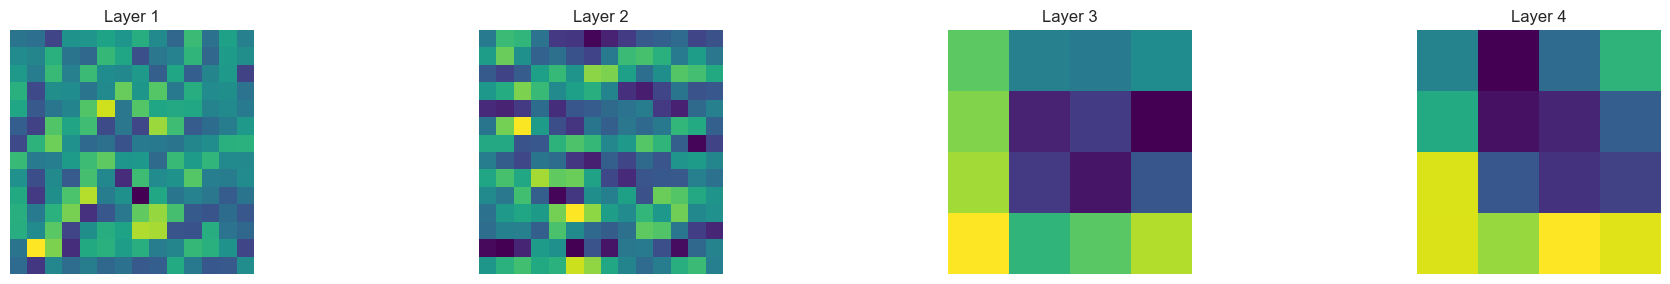

In [14]:
image = torch.randn(1, 3, 28, 28)
feature_map_visualize(model, image)

In [ ]:
from visualize_tool import weight_distribution_visualize

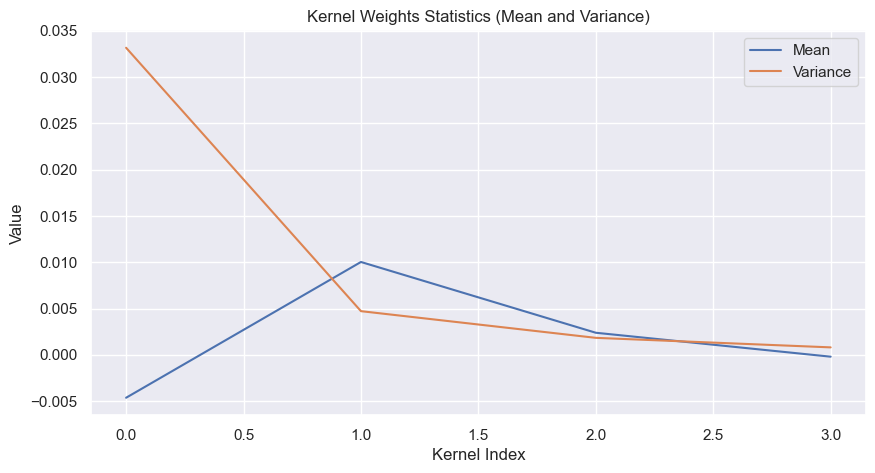

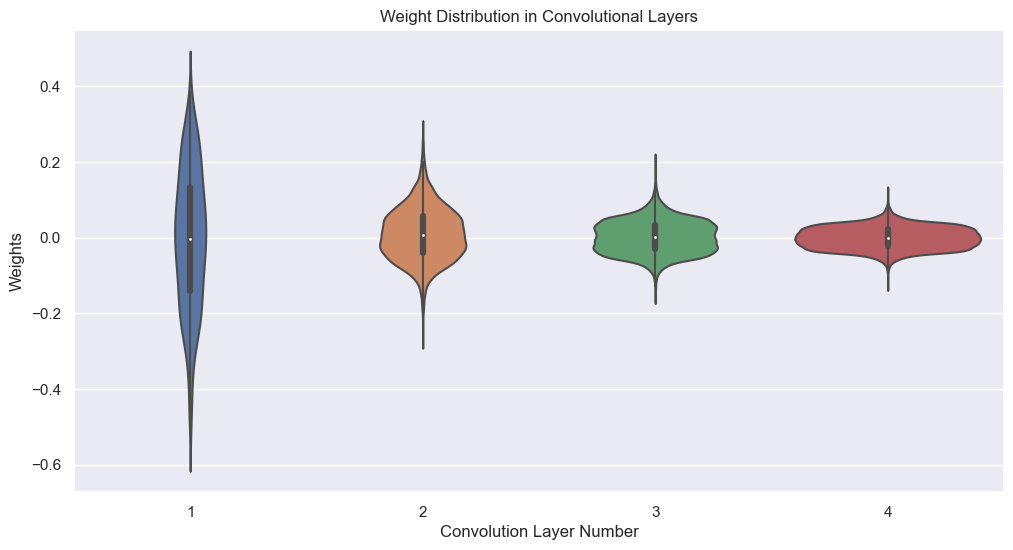

In [ ]:
weight_distribution_visualize(model)